# Network Analysis and Machine Learning - HW1

In this work, we aim to analyze LastFM - social network contains data about users and their connections with other users in Asia.
Our purpose is to find intersting insights about the network.

## Imports

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.algorithms import approximation
import json
import random
from functools import reduce


## Helpers

In [1]:
def plot_degree_histogram(G):
  degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
  dmax = max(degree_sequence)

  # Create a figure and the two subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  # Plot degree rank plot
  ax1.plot(degree_sequence, "b-", marker="o")
  ax1.set_title("Degree Rank Plot")
  ax1.set_ylabel("Degree")
  ax1.set_xlabel("Rank")

  # Plot degree histogram
  ax2.hist(degree_sequence, bins='auto', color='b', alpha=0.7, rwidth=0.85)
  ax2.set_title("Degree Histogram")
  ax2.set_xlabel("Degree")
  ax2.set_ylabel("# of Nodes")

  fig.tight_layout()
  plt.show()



In [22]:
def plot_node_targets(nodes):
  count_targets = nodes.groupby('target').count()
  plt.figure(figsize=(10, 6))
  sns.barplot(x='target', y='id', data=count_targets)
  plt.xlabel('Target')
  plt.ylabel('Count')
  plt.title('Count of Nodes in each Target')
  plt.show()

In [23]:
def print_top_10_centerality(top_degree_nodes):
  top_degree_nodes = dict(sorted(top_degree_nodes.items(), key=lambda item: item[1], reverse=True))
  i = 1
  for node, centrality in list(top_degree_nodes.items())[:10]:
    print(f"{i}. Node {node}: {centrality:.4f}")
    i += 1
  return list(top_degree_nodes.keys())[:10]

In [27]:
def top_ten_predictions(top_ten, nodes, features):
  for pair in top_ten:
    x = pair[0][0]
    y = pair[0][1]
    print(f"({x}, {y}), {pair[1]}")
    print(nodes.loc[(nodes['id'] == x) | (nodes['id'] == y) ])

  lst1 = features[x]
  lst2 = features[y]
  intersection = reduce(lambda acc, x: acc + [x] if x in lst2 and x not in acc else acc, lst1, [])

  print(len(intersection))

  lst1 = G[x]
  lst2 = G[y]
  intersection = reduce(lambda acc, x: acc + [x] if x in lst2 and x not in acc else acc, lst1, [])
  print(len(intersection))

## 1 - Preprocess

In [5]:
edges = pd.read_csv("/content/lastfm_asia_edges.csv")

In [6]:
nodes = pd.read_csv("/content/lastfm_asia_target.csv")

In [7]:
nodes

,id,target
0,0,8
1,1,17
2,2,3
3,3,17
4,4,5
...,...,...
7619,7619,10
7620,7620,10
7621,7621,0
7622,7622,17


In [8]:
G = nx.Graph()
G = G.to_undirected()
edges_touples = edges.apply(lambda x: (x['node_1'], x['node_2']), axis=1)
G.add_edges_from(edges_touples)

In [9]:
num_nodes = G.number_of_nodes()
print(f"Number of nodes in graph G: {num_nodes}")

Number of nodes in graph G: 7624


In [10]:
num_edges = G.number_of_edges()
print(f"Number of edges in graph G: {num_edges}")

Number of edges in graph G: 27806


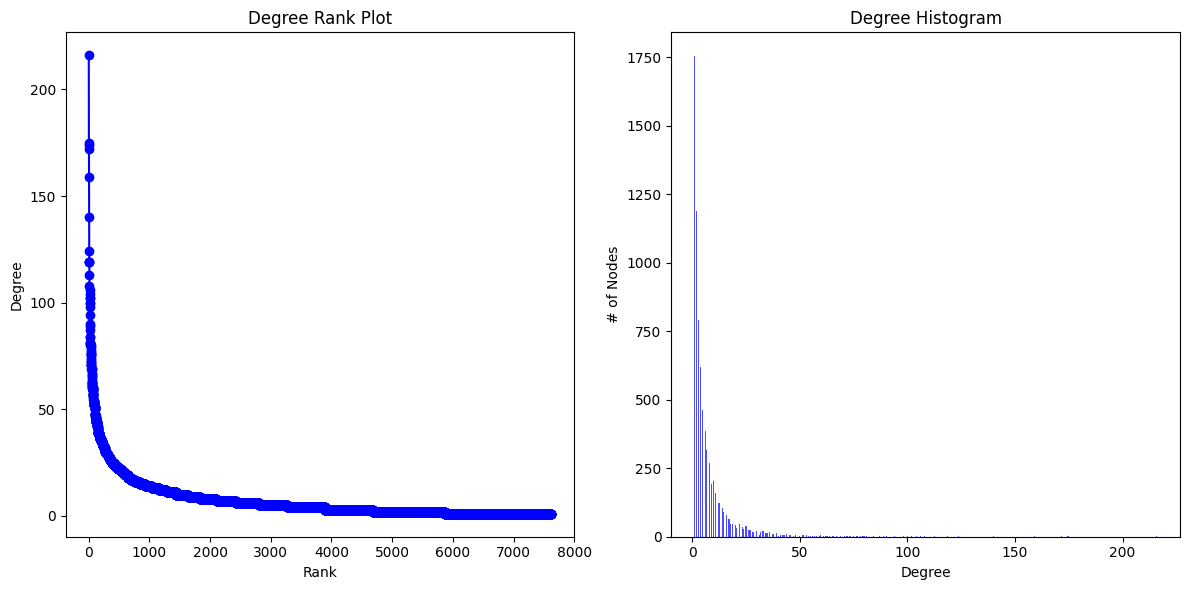

In [11]:
plot_degree_histogram(G)

In [12]:
small_degree_nodes = [node for node,degree in nx.degree(G) if degree < 2]
print(f"Number of nodes with degree less than 2: {len(small_degree_nodes)}")

Number of nodes with degree less than 2: 1754


In [13]:
G.remove_nodes_from(small_degree_nodes)

In [14]:
new_nodes = G.number_of_nodes()
print(f"Number of nodes after filtering nodes with degree less than 2: {new_nodes}")

Number of nodes after filtering nodes with degree less than 2: 5870


In [15]:
new_edges = G.number_of_edges()
print(f"Number of edges after filtering nodes with degree less than 2: {new_edges}")

Number of edges after filtering nodes with degree less than 2: 26052


In [16]:
# remove deleted node from nodes df
nodes = nodes[~nodes['id'].isin(small_degree_nodes)]
nodes.reset_index(drop=True, inplace=True)

In [17]:
file_path = '/content/lastfm_asia_features.json'

with open(file_path, "r") as file:
    json_data = json.load(file)


In [18]:
for node in small_degree_nodes:
  json_data.pop(str(node))

In [19]:
target_data = {}
features_data = {}
for key in json_data:
  features_data[int(key)] = json_data[str(key)][1:-1]
  target_data[int(key)] = nodes.loc[nodes['id'] == int(key)]['target'].values[0]


In [20]:
nx.set_node_attributes(G, features_data, 'features')
nx.set_node_attributes(G, target_data, 'target')

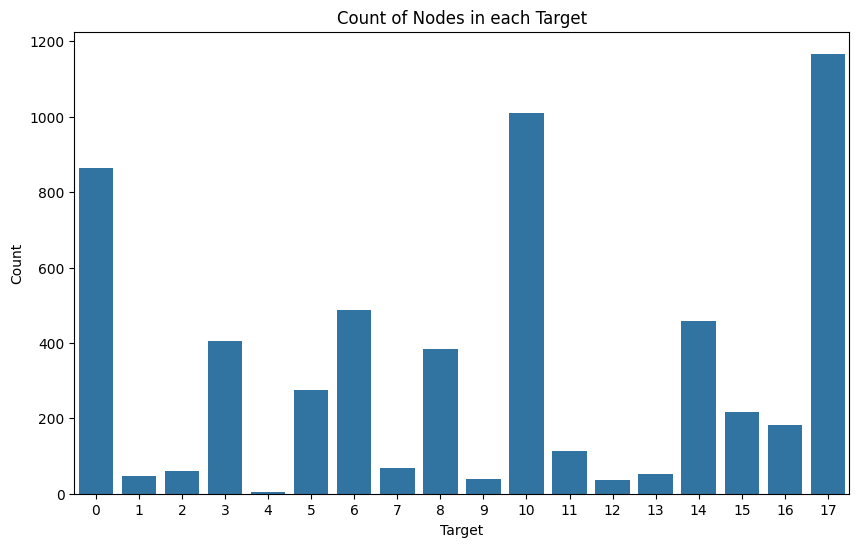

In [24]:
plot_node_targets(nodes)

## 2 - Properties

### Network Density

**Density** - the ratio between the actual number of edges and the maximum possible number of edges in the network

$$
\frac{edges}{N \cdot (N-1) \cdot \frac{1}{2}}
$$

In [28]:
density = nx.density(G)
print(f"The density of graph G is {density:.4f}")

The density of graph G is 0.0015


### Degree distribution

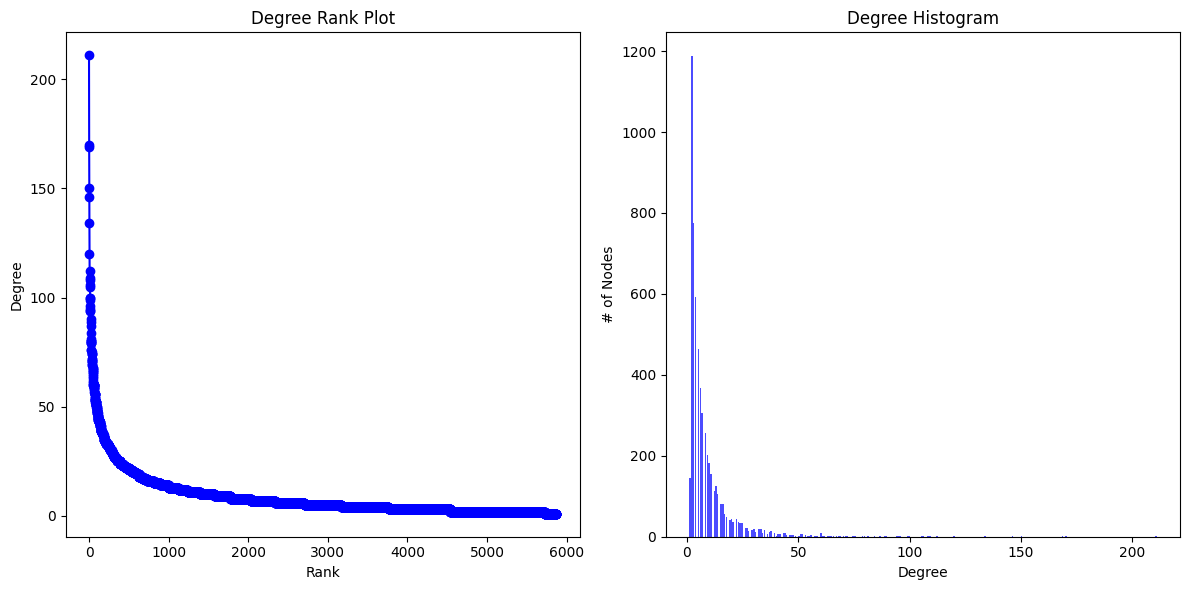

In [25]:
plot_degree_histogram(G)

We can see, that compared to the plot without filtering nodes with degree less than 2 - the general shapes of 2 plots remain similiar, but the probability and number of nodes that has samll degree decreased.
The probability decreased and not initiate since the removal of small degree nodes, may caused that other nodes has less neighbours and therfore they degree decreased.

### Diameter and Average Path Length

**Diameter:** The maximum shortest path/distance between any pair of nodes in a graph

$$
ħ= \sum_{u, v \neq u} \frac{h_u,_v}{N * (N-1) }
$$


In [29]:
diameter = nx.diameter(G)
print(f"The diameter of graph G is {diameter}")

The diameter of graph G is 13


In [30]:
average_path_length = nx.average_shortest_path_length(G)
print(f"The average path length of graph G is {average_path_length:.2f}")

The average path length of graph G is 4.87


### Clustering Coefficient

In [31]:
cluster_coef = approximation.average_clustering(G)

In [32]:
cluster_coef

0.315

## 3 - Centrality

In [35]:
top_10_nodes = []

### Degree Centrality

In [36]:
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

In [37]:
top_dc = print_top_10_centerality(degree_centrality)

1. Node 7237: 0.0360
2. Node 524: 0.0290
3. Node 3530: 0.0288
4. Node 3450: 0.0256
5. Node 4785: 0.0249
6. Node 2510: 0.0228
7. Node 3597: 0.0204
8. Node 6101: 0.0191
9. Node 5127: 0.0186
10. Node 2854: 0.0184


In [38]:
top_10_nodes += top_dc

### Betweenness Centrality

In [39]:
betweenness_centrality = nx.betweenness_centrality(G, new_nodes)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

In [40]:
top_bc = print_top_10_centerality(betweenness_centrality)

1. Node 7237: 0.0888
2. Node 7199: 0.0877
3. Node 2854: 0.0734
4. Node 4356: 0.0663
5. Node 6101: 0.0503
6. Node 4338: 0.0417
7. Node 5454: 0.0412
8. Node 3450: 0.0365
9. Node 5127: 0.0356
10. Node 3103: 0.0343


In [41]:
top_10_nodes += top_bc

### Closeness Centrality

In [42]:
closeness_centrality = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')


In [43]:
top_cc = print_top_10_centerality(closeness_centrality)

1. Node 7199: 0.3067
2. Node 7237: 0.3017
3. Node 4356: 0.2970
4. Node 2854: 0.2941
5. Node 5454: 0.2934
6. Node 6101: 0.2879
7. Node 3544: 0.2875
8. Node 5127: 0.2873
9. Node 3450: 0.2851
10. Node 4900: 0.2827


In [44]:
top_10_nodes += top_cc

### Eigenvector Centrality

In [45]:
eigenvector_centrality = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector_centrality')

In [46]:
top_ec = print_top_10_centerality(eigenvector_centrality)

1. Node 7237: 0.2556
2. Node 3240: 0.1966
3. Node 3597: 0.1906
4. Node 763: 0.1819
5. Node 378: 0.1644
6. Node 2083: 0.1629
7. Node 1334: 0.1628
8. Node 3544: 0.1516
9. Node 4809: 0.1515
10. Node 2734: 0.1467


In [47]:
top_10_nodes += top_ec

In [48]:
top_10_nodes = set(top_10_nodes)

### Get top 10

In [ ]:
import csv

with open('top_ten.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header
    writer.writerow(['node', 'country', 'features', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality'])
    for node, attr in G.nodes(data=True):
      if node in top_10_nodes:
        writer.writerow([node,attr['target'], attr['features'], attr['degree_centrality'], attr['betweenness_centrality'], attr['closeness_centrality'], attr['eigenvector_centrality']])


747


In [ ]:
nx.write_gexf(G,'G-update.gexf')

## 6 - Feature Analysis

In [49]:
nodes

,id,target
0,1,17
1,2,3
2,3,17
3,6,3
4,7,6
...,...,...
5865,7618,17
5866,7620,10
5867,7621,0
5868,7622,17


In [50]:
# class is a file contain for each node its community
modularity_gephi = pd.read_csv('/content/class.csv')
modularity_gephi = modularity_gephi.sort_values(by='id')
modularity_gephi = modularity_gephi.reset_index()
nodes['class'] = modularity_gephi['class']

<ipython-input-50-afa1c30cd2b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes['class'] = modularity_gephi['class']


In [51]:
modularity_gephi

,index,id,class,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,0,1,10,NaN,NaN,NaN,NaN,NaN,NaN
1,10,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2,18,3,10,NaN,NaN,NaN,NaN,NaN,NaN
3,13,6,0,NaN,NaN,NaN,NaN,NaN,NaN
4,55,7,3,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5865,1914,7618,10,NaN,NaN,NaN,NaN,NaN,NaN
5866,1726,7620,8,NaN,NaN,NaN,NaN,NaN,NaN
5867,2572,7621,4,NaN,NaN,NaN,NaN,NaN,NaN
5868,5842,7622,10,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
nodes_dict = nodes.to_dict('index')

In [53]:
com_dict_modularity = {}
for node in nodes_dict:
  node_id = nodes_dict[node]['id']
  cls = nodes_dict[node]['class']
  if cls in com_dict_modularity:
    com_dict_modularity[cls].append(node_id)
  else:
    com_dict_modularity[cls] = [node_id]

In [54]:
artists = {}
new_artists = []
i = 0
for node in json_data:
  node_artists = json_data[node]
  key_node = int(node)
  for artist in node_artists:
    key_artist = int(artist)
    if key_artist in artists:
      artists[key_artist].append(key_node)
    else:
      artists[key_artist] = [key_node]

In [55]:
community_artists = {}
community_countries = {}
nodes_community = {}
for community in com_dict_modularity:
  community_artists[community] = {}
  community_countries[community] = {}
  for node in com_dict_modularity[community]:
    node_artists = json_data[str(node)]
    node_country = nodes[nodes['id'] == node]['target'].values[0]
    if node_country in community_countries[community]:
       community_countries[community][node_country] += 1
    else:
      community_countries[community][node_country] = 1
    for artist in node_artists:
      if artist in community_artists[community]:
        community_artists[community][artist] += 1
      else:
        community_artists[community][artist] = 1

In [56]:
top_artists_per_community = {}
for community in community_artists:
  top_artists_per_community[community] = {}
  total_artists = len(community_artists[community])
  for artist in community_artists[community]:
    p = community_artists[community][artist] / total_artists * 100
    top_artists_per_community[community][artist] = p

for community in top_artists_per_community:
  top_artists_per_community[community] = sorted(top_artists_per_community[community].items(), key=lambda item: item[1], reverse=True)[:5]


In [57]:
pd_community = {'community' : [], 'artist' : [], 'prec' : []}
for community in top_artists_per_community:
  for artist in top_artists_per_community[community]:
    pd_community['community'].append(community)
    pd_community['artist'].append(artist[0])
    pd_community['prec'].append(artist[1])

pd_community = pd.DataFrame(pd_community)

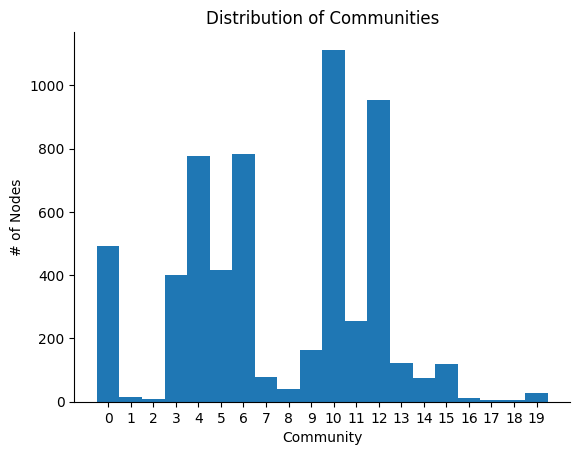

In [58]:
# Plotting the histogram
ax = nodes['class'].plot(kind='hist', bins=20, title='Distribution of Communities')

# Removing the top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Setting the titles
plt.title('Distribution of Communities')
plt.xlabel('Community')
plt.ylabel('# of Nodes')

# Updating the x-axis tick labels to be unique integer values in the middle of each bin
bin_edges = ax.patches[0].get_x() + ax.patches[0].get_width()
bin_centers = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]
bin_labels = [int(round(center)) for center in bin_centers]
unique_labels = list(dict.fromkeys(bin_labels))  # Ensure the labels are unique
ax.set_xticks(bin_centers)
ax.set_xticklabels(unique_labels)

plt.show()

<ipython-input-59-99f8eed6e8b4>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(countries))


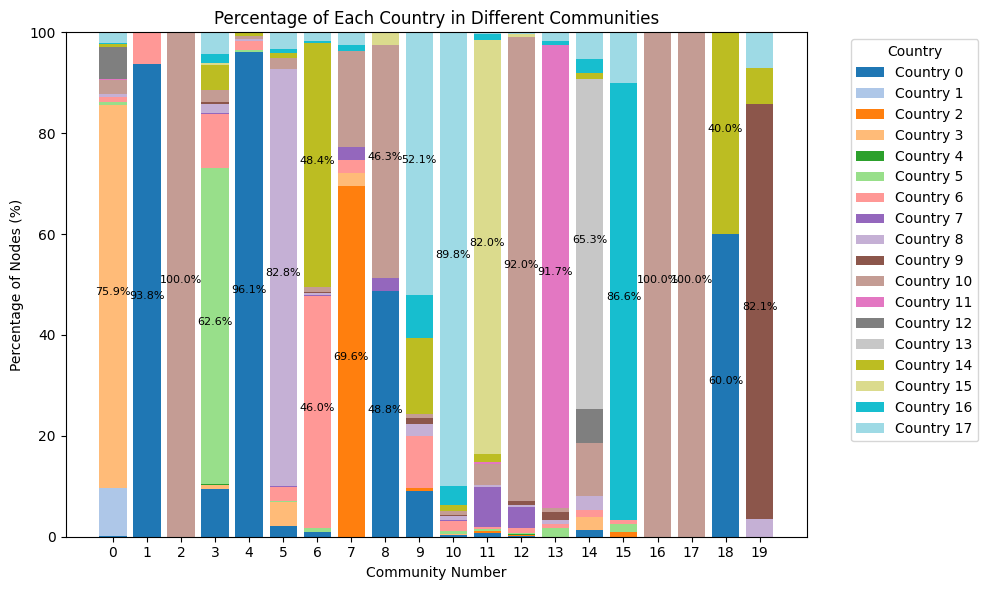

In [59]:
# Calculate node counts for each community and country


# Aggregate data to calculate percentage of each country in each community
agg_df = nodes.groupby('class')['target'].value_counts(normalize=True).mul(100).reset_index(name='percentage')

# Pivot table to reshape data for plotting
pivot_df = agg_df.pivot_table(index='class', columns='target', values='percentage', fill_value=0)

# Sort columns by index (target) and convert to list
columns_sorted = pivot_df.columns.sort_values().tolist()

# Reindex pivot table to ensure columns are sorted
pivot_df = pivot_df.reindex(columns=columns_sorted)


# Generate random colors for each country
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each country (assuming len(countries) colors are defined)
countries = pivot_df.columns.astype(int).tolist()
colors = plt.cm.get_cmap('tab20', len(countries))

# Plot stacked bars
bars = []
bottom = np.zeros(len(pivot_df))
for i, country in enumerate(countries):
    bars.append(ax.bar(pivot_df.index, pivot_df[country], bottom=bottom, label=f'Country {country}', color=colors(i)))
    bottom += pivot_df[country]

# Annotate percentages within bars for values greater than 20%
for bar in bars:
    for rect in bar:
        height = rect.get_height()
        if height > 20:  # Adjust the threshold here as needed
            ax.annotate(f'{height:.1f}%', xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + rect.get_height() / 2),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='center', fontsize=8)

# Labeling axes
ax.set_xlabel('Community Number')
ax.set_ylabel('Percentage of Nodes (%)')

# Set numeric community numbers as x-axis ticks
ax.set_xticks(pivot_df.index)
ax.set_xticklabels(pivot_df.index)

# Sort legend items numerically
handles, labels = ax.get_legend_handles_labels()
sorted_labels = sorted(labels, key=lambda label: int(label.split()[1]))
sorted_handles = [handles[labels.index(label)] for label in sorted_labels]
ax.legend(sorted_handles, sorted_labels, title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding title to the plot
ax.set_title('Percentage of Each Country in Different Communities')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


<ipython-input-60-c3bb1da45c80>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Pastel1', 5)


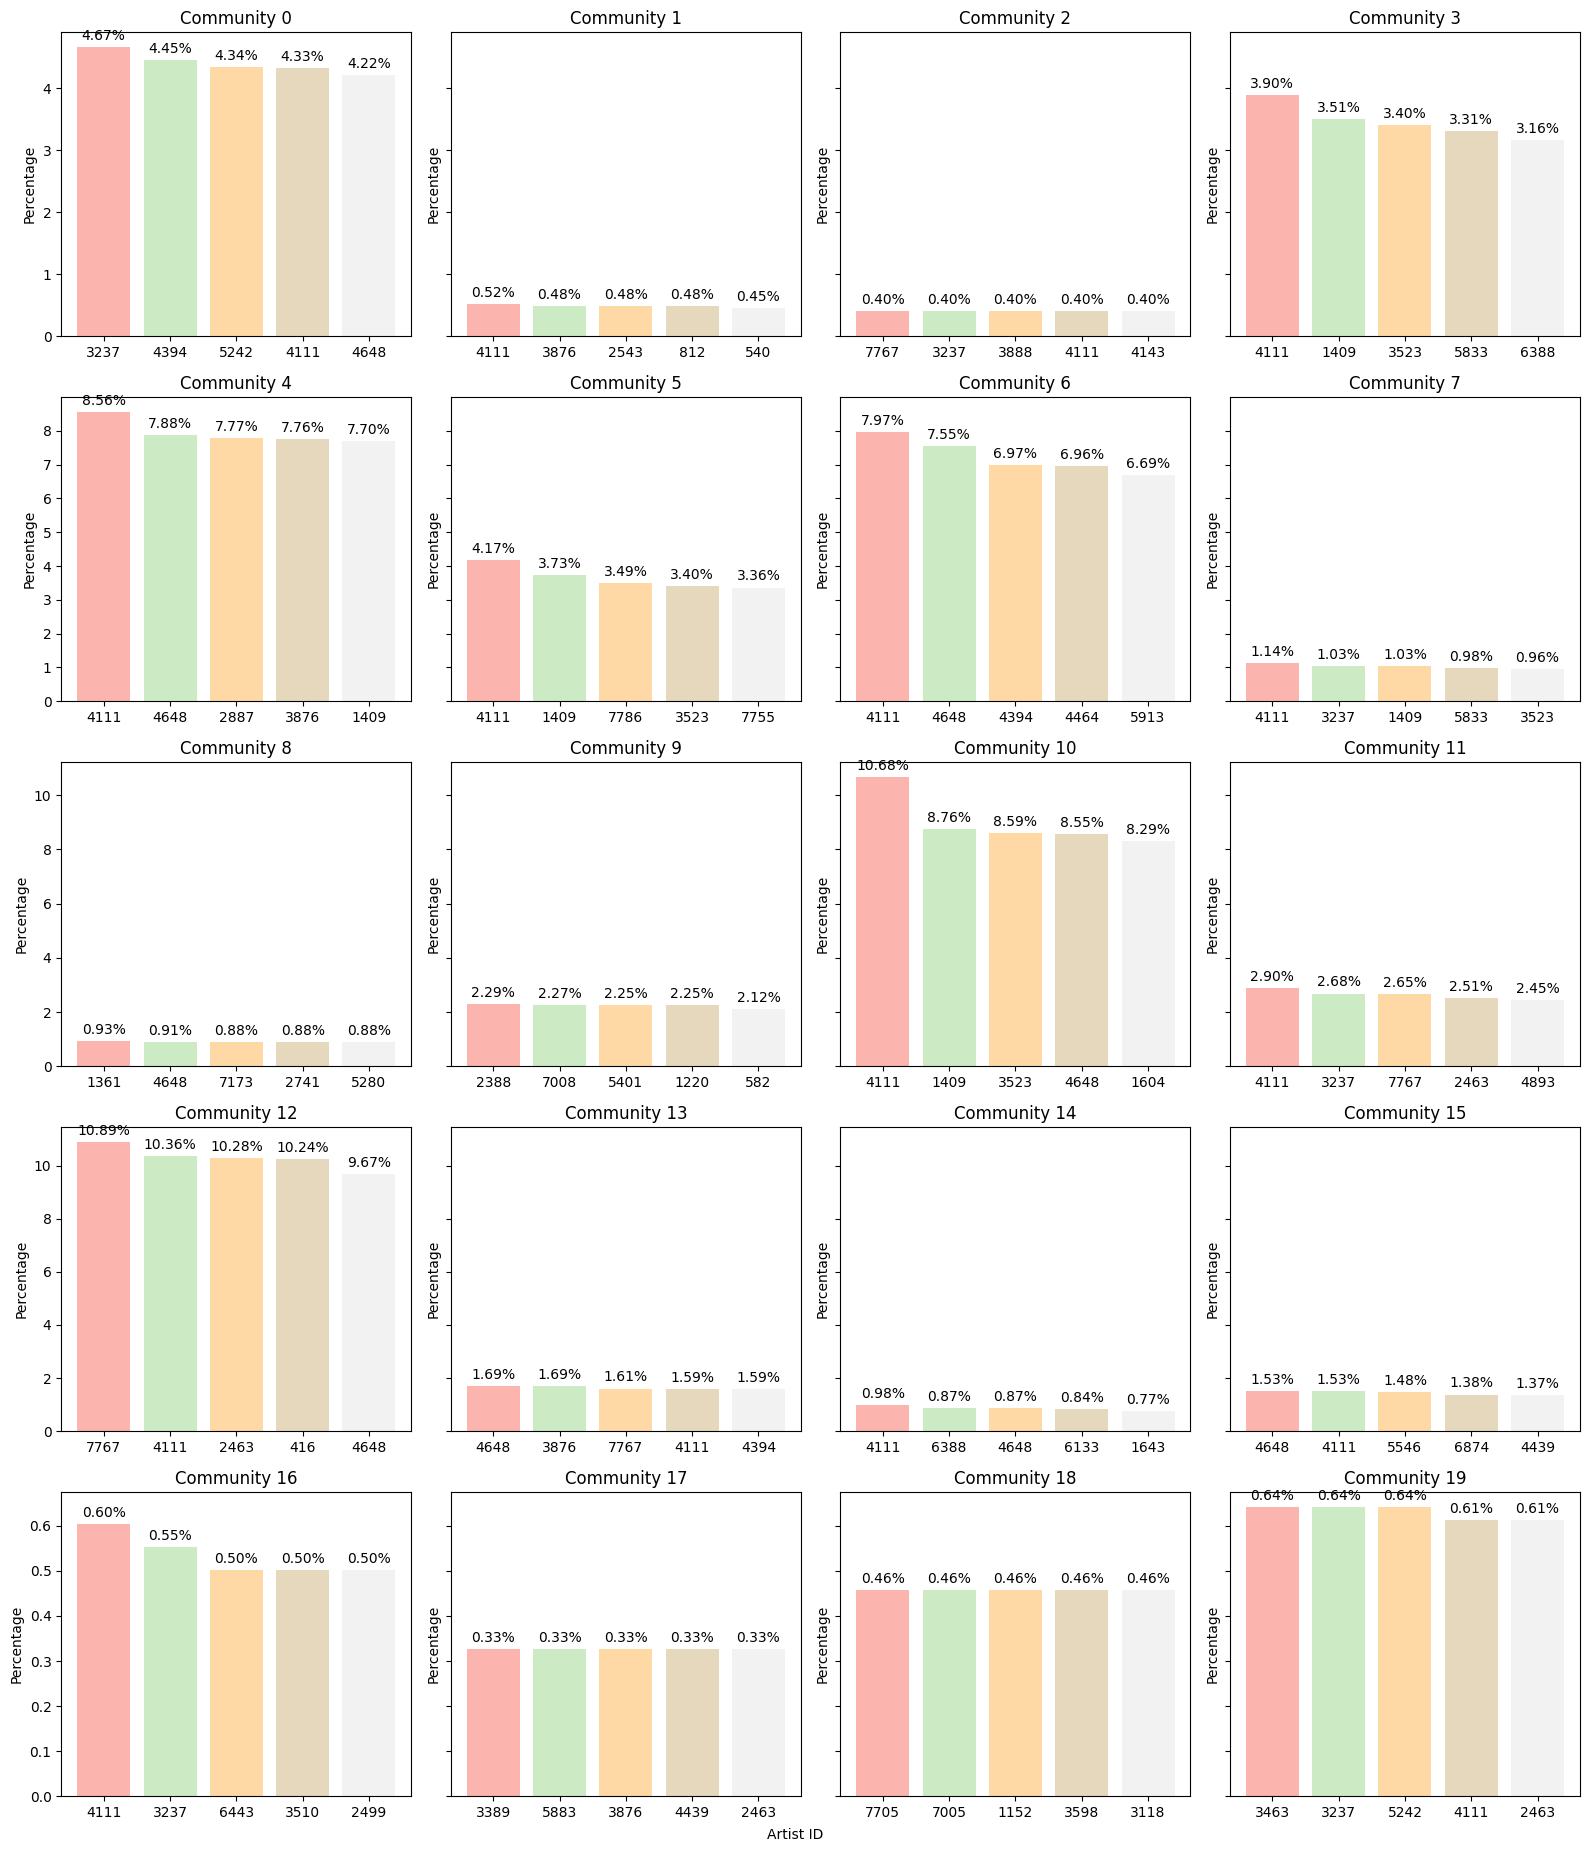

In [60]:
from matplotlib.patches import Patch


df = pd.DataFrame(pd_community)

# Get unique communities
communities = sorted(df['community'].unique())
# Increase height of each subplot
# Number of rows and columns for the grid of plots
num_rows = 5
num_cols = 4

# Create a larger plot with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 20), sharey='row')  # Adjust figsize as needed

# Choose a pastel colormap
colors = plt.cm.get_cmap('Pastel1', 5)

# Iterate over each community and plot in the grid
for idx, community in enumerate(communities):
    row = idx // num_cols
    col = idx % num_cols
    ax = axs[row, col]

    community_data = df[df['community'] == community].nlargest(5, 'prec')

    # Plot the data with pastel colors
    bars = ax.bar(community_data['artist'].astype(str), community_data['prec'], color=[colors(i) for i in range(5)])

    # Annotate bars with percentages
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',  # Format as percentage with two decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text by 3 points above the bar
                    textcoords='offset points',
                    ha='center', va='bottom')

    # Labeling
    ax.set_ylabel('Percentage')
    ax.set_title(f'Community {community}')
    ax.set_xticks(community_data['artist'].astype(str))  # Set x-ticks to only the top 5 artists

    # Create legend with artist IDs
    legend_handles = [Patch(color=colors(i), label=f'{artist}') for i, artist in enumerate(community_data['artist'].head(5))]
    # ax.legend(handles=legend_handles, loc='upper right')

# Add common x-label and adjust layout
fig.text(0.5, 0.04, 'Artist ID', ha='center', va='center')
plt.tight_layout(rect=[0, 0.04, 1, 0.96])  # Adjust rect to leave space for xlabel

# Show the plot
plt.show()


## 7 - Link Prediction

### Adamic Adar

In [61]:
preds_adamic_adar = nx.adamic_adar_index(G)


pred_dict_adamic_adar = {}
for u, v, p in preds_adamic_adar:
    pred_dict_adamic_adar[(u,v)] = p

In [62]:
top_ten_aa = sorted(pred_dict_adamic_adar.items(), key=lambda x:x[1], reverse=True)[:10]

In [63]:
top_ten_predictions(top_ten_aa, nodes, features_data)

(290, 3597), 13.553631112870649
        id  target  class
212    290       0      4
2759  3597       0      4
(1057, 6241), 13.267516499206351
        id  target  class
796   1057      16     15
4789  6241      16     15
(2591, 4785), 12.357108650493029
        id  target  class
1967  2591       6      6
3674  4785       6      6
(3360, 7224), 11.107693565394236
        id  target  class
2567  3360      14      6
5557  7224      14      6
(3038, 3853), 10.358079498592025
        id  target  class
2315  3038      14      6
2959  3853      14      6
(2848, 3251), 10.321386854317668
        id  target  class
2166  2848       0      4
2482  3251       0      4
(378, 2083), 10.314061147610714
        id  target  class
279    378       0      4
1590  2083       0      4
(290, 6891), 10.164889051002366
        id  target  class
212    290       0      4
5299  6891       6      4
(4000, 7224), 9.766529517403216
        id  target  class
3073  4000      14      6
5557  7224      14      6
(2510

### Jaccard

In [64]:
preds_jaccard = nx.jaccard_coefficient(G)


pred_dict_jaccard = {}
for u, v, p in preds_jaccard:
    pred_dict_jaccard[(u,v)] = p

sorted(pred_dict_jaccard.items(), key=lambda x:x[1], reverse=True)[:10]

[((42, 234), 1.0),
 ((350, 6677), 1.0),
 ((391, 2801), 1.0),
 ((583, 6824), 1.0),
 ((755, 1063), 1.0),
 ((874, 4579), 1.0),
 ((1076, 4351), 1.0),
 ((1076, 7181), 1.0),
 ((1123, 3903), 1.0),
 ((1252, 7283), 1.0)]

In [65]:
top_ten_j = sorted(pred_dict_jaccard.items(), key=lambda x:x[1], reverse=True)[:10]

In [66]:
top_ten_predictions(top_ten_j, nodes, features_data)

(42, 234), 1.0
      id  target  class
31    42       0      4
172  234       0      4
(350, 6677), 1.0
        id  target  class
260    350       6      6
5126  6677       6      6
(391, 2801), 1.0
        id  target  class
289    391       6      6
2125  2801       6      6
(583, 6824), 1.0
        id  target  class
436    583      17      0
5244  6824       3      0
(755, 1063), 1.0
       id  target  class
568   755       0      6
801  1063       0      6
(874, 4579), 1.0
        id  target  class
657    874      10     12
3520  4579      10     12
(1076, 4351), 1.0
        id  target  class
810   1076       0      4
3353  4351       0      4
(1076, 7181), 1.0
        id  target  class
810   1076       0      4
5523  7181       0      4
(1123, 3903), 1.0
        id  target  class
843   1123       9     19
2995  3903      17     19
(1252, 7283), 1.0
        id  target  class
943   1252       7     12
5600  7283       7     12
21
2


## 8 - Top ten analysis

In [67]:
top_ten_community = {'node':[], 'community':[], 'target':[]}
for node in G.nodes():
  if node in top_10_nodes:
    node_community = nodes.loc[nodes['id'] == node]['class'].values[0]
    node_target = nodes.loc[nodes['id'] == node]['target'].values[0]
    top_ten_community['node'].append(node)
    top_ten_community['community'].append(node_community)
    top_ten_community['target'].append(node_target)


In [68]:
top_ten_community = pd.DataFrame(top_ten_community)

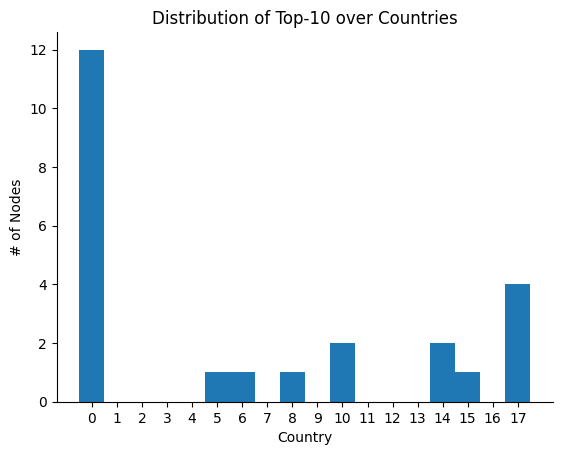

In [69]:
# Creating the DataFrame with sample data
# Plotting the histogram
ax = top_ten_community['target'].plot(kind='hist', bins=18, title='Distribution of Top-10 over Countries')

# Removing the top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Setting the titles
plt.title('Distribution of Top-10 over Countries')
plt.xlabel('Country')
plt.ylabel('# of Nodes')

# Updating the x-axis tick labels to be unique integer values in the middle of each bin
bin_edges = ax.patches[0].get_x() + ax.patches[0].get_width()
bin_centers = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]
bin_labels = [int(round(center)) for center in bin_centers]
unique_labels = list(range(18))  # Ensure the labels are unique
ax.set_xticks(bin_centers)
ax.set_xticklabels(unique_labels)

plt.show()
